## What neighbourhoods share similarities based on Airbnb reviews in Ottawa, ON, Canada?

In the first two analyses we built a distribution of Airbnbs by neighbourhood in the city of Ottawa, ON, Canada, and then we created clusters based on region, unit details, and building type.  In this analysis we look at building clusters based on user reviews while keeping geospatial location in consideration through spatial weights.  This analysis was inspired by [Geographic Data Science with PySAL and the pydata stack](http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html).

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import re
import os
if not os.path.exists('images'):
    os.makedirs('images')
%matplotlib inline

sns.set(style="whitegrid")

/home/rshaheen/condapv/envs/test_clone/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/home/rshaheen/condapv/envs/test_clone/lib/python3.7/site-packages/numba/decorators.py:33: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


Just like in the first two analyses we import `listings.csv` and `neighbourhoods.geojson` into `listings` and `ottawa` dataframes, respectively.

In [2]:
listings = pd.read_csv("./listings.csv")
ottawa = gpd.read_file("./neighbourhoods.geojson")

In [3]:
ottawa.head()

,neighbourhood,neighbourhood_group,geometry
0,Rideau-Goulbourn,None,"MULTIPOLYGON Z (((-75.79872 45.29269 0.00000, ..."
1,Rideau-Vanier,None,"MULTIPOLYGON Z (((-75.65350 45.44392 0.00000, ..."
2,Orleans,None,"MULTIPOLYGON Z (((-75.50771 45.46143 0.00000, ..."
3,West Carleton-March,None,"MULTIPOLYGON Z (((-76.08706 45.51833 0.00000, ..."
4,Cumberland,None,"MULTIPOLYGON Z (((-75.32030 45.50050 0.00000, ..."


First we want to isolate the ratings columns.  To do this we look for the `'review_scores_'` string patterns in the features headers and then extract those column headers from the listings df.

In [4]:
ratings_cols = [i for i in listings if 'review_scores_' in i]
ratings_cols

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

Now we want to look at the average ratings at a neighbourhood level.  We want to scale the results to not let ratings out of 100 have more weight than ratings out of 5 or 10.  We use a min max scaler to map all ratings to values between 0, 1.

In [5]:
ratings_avg = listings.groupby('neighbourhood_cleansed')[ratings_cols].mean()
scaler = MinMaxScaler()
scaler.fit(ratings_avg)
ratings_avg = pd.DataFrame(scaler.transform(ratings_avg), index=ratings_avg.index, columns=ratings_avg.columns)

Now we link the `ratings_avg` table to the geometries on `ottawa` by neighbourhood lookup.

In [6]:
neighbourhood_ratings_avg = ottawa[['neighbourhood', 'geometry']].join(ratings_avg, on='neighbourhood').dropna()
neighbourhood_ratings_avg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 9 columns):
neighbourhood                  23 non-null object
geometry                       23 non-null geometry
review_scores_rating           23 non-null float64
review_scores_accuracy         23 non-null float64
review_scores_cleanliness      23 non-null float64
review_scores_checkin          23 non-null float64
review_scores_communication    23 non-null float64
review_scores_location         23 non-null float64
review_scores_value            23 non-null float64
dtypes: float64(7), geometry(1), object(1)
memory usage: 1.8+ KB


We will construct a weights matrix using Queen Contiguity, which defines a neighbour by a shared edge or vertex, to illustrate the topological relation of the demographic reagions in our city.

In [7]:
w_queen = Queen.from_dataframe(neighbourhood_ratings_avg)

Below illustrates the neighbours of the regions in `ottawa` according to queens contiguity.

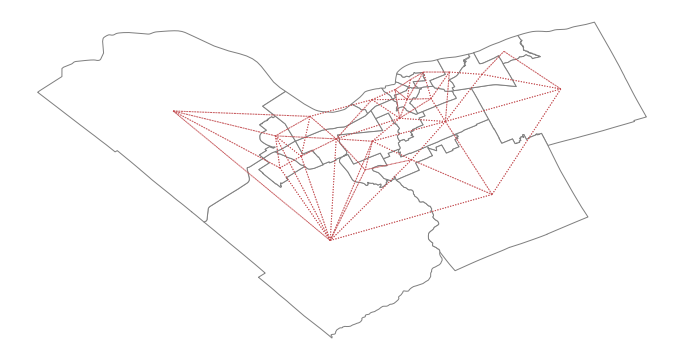

In [8]:
ax = neighbourhood_ratings_avg.plot(edgecolor='grey', facecolor='w', figsize=(12, 10))
w_queen.plot(neighbourhood_ratings_avg, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
plt.savefig('./images/'+'w_queen_contiguity'+'.png', dpi=300, bbox_inches='tight', pad_inches=0)

We want to run a regionalization aglorithm and will use max-p from pysal.  Max-p is a clustering algorithm that, instead of pre-defining the number of clusters, uses a target variable (number of reviews in our case) to makes sure a minumum threshold is met.  In this analysis, we will make sure each cluster uses atleast 10% of the total reviews.

In [9]:
num_reviews = listings.groupby('neighbourhood_cleansed').sum()\
           ['number_of_reviews']\
           .reindex(ottawa['neighbourhood'])
num_reviews_threshold = np.round(0.1 * num_reviews.sum())
num_reviews_threshold

10166.0

This means that in our case we want to make sure that each cluster has atleast 10166 reviews.

In [10]:
np.random.seed(42)
df = neighbourhood_ratings_avg.drop(['geometry', 'neighbourhood'], axis=1).values
maxp = ps.region.Maxp(w_queen, df, num_reviews_threshold, num_reviews.values[:, None], initial=1000)

We want to check if the solution is better than pure chance so we check the empirical pvalue.

In [11]:
np.random.seed(42)
maxp.cinference(nperm=999)
maxp.cpvalue

0.001

At 0.001 it's acceptable that the results were not coincidental.  Let's map the regions that were determined based on similar reviews.

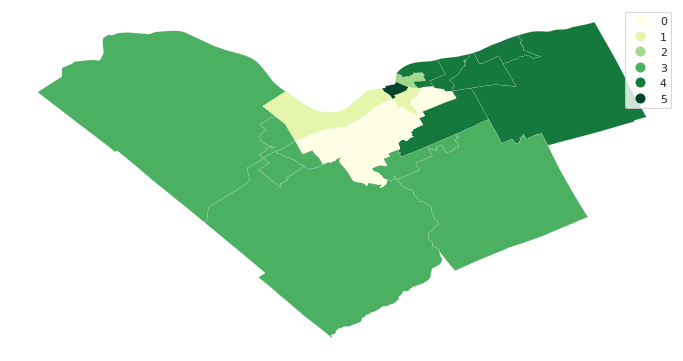

In [12]:
f, ax = plt.subplots(1, figsize=(12, 10))
clustered_df = neighbourhood_ratings_avg.assign(cl=pd.Series(maxp.area2region))
clustered_df.plot(column='cl', categorical=True, legend=True,\
                        linewidth=0.1, edgecolor='white', ax=ax, cmap='YlGn')
ax.set_axis_off();
plt.savefig('./images/'+'review_clusters_w_queen'+'.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

The map clearly shows a distribution based on regions.  Lets see the cluster regions and how the reviews map out in each.

In [13]:
round(clustered_df.groupby('cl').mean().T*100,1)

cl,0,1,2,3,4,5
review_scores_rating,59.3,71.8,14.0,76.8,38.3,19.0
review_scores_accuracy,63.3,90.2,34.4,83.2,38.0,42.5
review_scores_cleanliness,52.8,67.0,24.8,73.3,32.3,14.8
review_scores_checkin,65.0,82.3,50.3,90.1,36.7,51.9
review_scores_communication,67.8,82.6,47.1,86.5,42.8,43.9
review_scores_location,56.3,92.2,50.5,56.0,36.6,77.8
review_scores_value,57.4,56.3,0.0,67.3,28.6,7.4


Here we can see that `3` has the best overall ratings while `5` has the worst.  `5` is, in fact, the downtown core of Ottawa and has great location reviews but overall the units are not highly regarded.  The best area across the board seems to be `1` which is located in the trendy neighbourhoods of Ottawa.  With the best location score, as well as high marks in checkin, communication, and accuracy it seems that these neighbourhoods have great value. `3`, cottage country, has the best overall value score with the best scores in rating, cleanliness, checkin, communication, and value.  This area was found to have the most expensive units in the earlier analysis and therefore we can draw a correlation between price service level. 